# Training of vision model to identify the 100 selected plant species


In [25]:
from fastai.vision.all import *
import timm

In [2]:
#Define directories
data_dir = Path("../data")
img_dir = data_dir/"images_preproc"
model_dir = data_dir/"model"

In [3]:
len(get_image_files(img_dir))

24721


In [6]:
#Define function to get dataloader with different image and batch size
def get_dls(bs, size):
    dl = ImageDataLoaders.from_folder(
        path = img_dir, 
        valid_pct = 0.2, 
        bs = bs, 
        item_tfms = Resize(460),
        batch_tfms = aug_transforms(size=size, min_scale=0.85))
    return(dl)

In [11]:
#Get dataloader with lower resolution images for first round of training
#Second round of training will use higher resolution images (progressive resizing)
dls = get_dls(128, 112)

In [20]:
#Use model from the timm library
#Here we use a pretrained light-weight efficientnet
learn = vision_learner(dls, 
                       "efficientnet_b0",
                       pretrained=True,
                       loss_func=CrossEntropyLossFlat(),
                       metrics=[accuracy, top_k_accuracy]).to_fp16()

In [21]:
#First round of training
learn.fit_one_cycle(20, 1e-3)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,6.083572,4.847067,0.030138,0.107605,00:30
1,5.308138,4.165870,0.092638,0.265777,00:30
2,4.507765,3.702747,0.153924,0.385720,00:30
3,3.927172,3.359918,0.211165,0.470267,00:30
4,3.446217,3.089555,0.263350,0.536206,00:30
5,3.125949,2.867560,0.306837,0.580299,00:30
6,2.883027,2.746693,0.320793,0.606392,00:31
7,2.684064,2.608181,0.353964,0.635316,00:30
8,2.533196,2.536852,0.369134,0.647856,00:30
9,2.398789,2.451955,0.385113,0.665251,00:31


In [22]:
#Replace dataloader and loss function for second round of training
learn.dls = get_dls(64, 224)
learn.loss_func = LabelSmoothingCrossEntropy()

In [23]:
#Second round of training
learn.fit_one_cycle(10, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.773780,2.309943,0.572816,0.830299,00:50
1,2.682797,2.239185,0.583333,0.843042,00:50
2,2.580731,2.191105,0.596481,0.852346,00:50
3,2.555274,2.155911,0.608010,0.857807,00:49
4,2.493763,2.141192,0.610235,0.860235,00:50
5,2.439973,2.141587,0.610841,0.859021,00:49
6,2.417552,2.134207,0.612864,0.856796,00:49
7,2.402083,2.120783,0.616505,0.860437,00:49
8,2.376252,2.117362,0.617921,0.863066,00:49
9,2.388927,2.123106,0.621157,0.860032,00:49


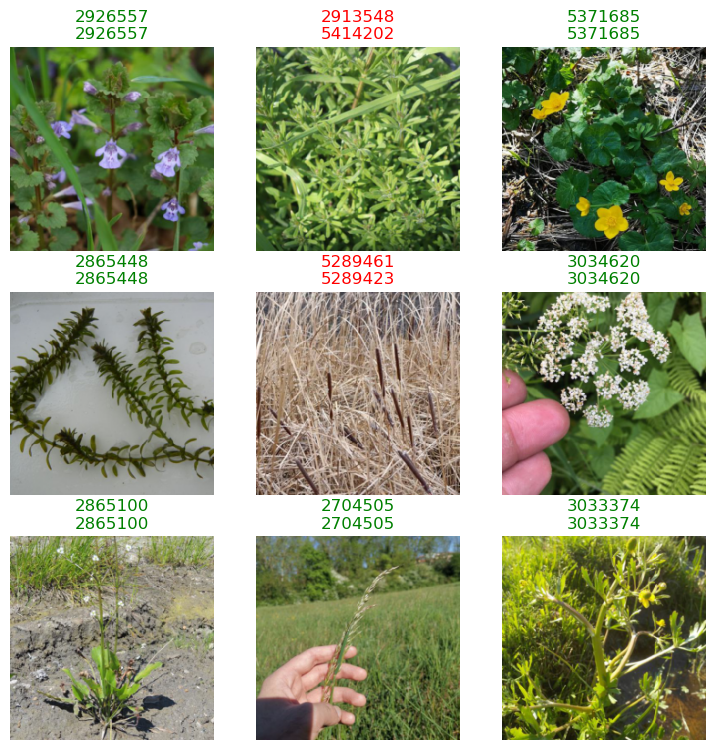

In [32]:
#Show example classifications
learn.show_results()

In [34]:
#Save model
learn.path = model_dir
learn.export("effnet_b0.export")